The purpose of this project is to perform topic modeling on data scraped from glassdoor.com

For more info on how the data was collected, please see [https://github.com/djkjohnston/glassdoor_scrape](https://github.com/djkjohnston/glassdoor_scrape)

In [1]:
import pandas as pd
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
import re
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [38]:
interviews = pd.read_csv('data/zillow_interviews.csv')

In [39]:
interviews.head()

,application_proccess,company,interview_description,interview_difficulty,interview_experience,interview_questions,job_title,offer_status,review_date
0,I applied online. The process took 2 weeks. I ...,Zillow,Discussions with the recruiter were positive a...,Easy Interview,Negative Experience,NaN,Senior Software Engineer,No Offer,"Jan 9, 2018"
1,I applied online. The process took 2 weeks. I ...,Zillow,2 Phone calls. 1 call with a recruiter. 1 call...,Average Interview,Positive Experience,"Tell me about your experience ,Answer Question",Account Executive,Accepted Offer,"Jan 18, 2018"
2,I applied online. The process took 4+ weeks. I...,Zillow,"I applied online. Within a couple days, a recr...",Average Interview,Positive Experience,Why are you looking to leave your current job...,Data Analyst,Accepted Offer,"Jan 16, 2018"
3,The process took 4 weeks. I interviewed at Zil...,Zillow,"Very efficient, friendly process that started ...",Average Interview,Positive Experience,"Why Zillow? ,Answer Question, What motivate...",Business Consultant,Accepted Offer,"Jan 5, 2018"
4,I applied through an employee referral. I inte...,Zillow,Was contacted by a recruiter who then set up a...,Easy Interview,Neutral Experience,"- Tell me about yourself,- Tell me about a ma...",Marketing Strategy,Declined Offer,"Jan 8, 2018"


In [40]:
interviews['interview_description'][0]

"Discussions with the recruiter were positive and courteous. I felt like Zillow understood my background and wanted to work with me. The moment I spoke with an engineer, though, I felt differently. All he wanted to do was talk about himself. He barely asked me a thing about my experience or what I was interested in. I am a very senior person who was asked a low-ball question. I provided a good, efficient answer and tested it well, but still got rejected. Pretty short-sighted. I've worked with too many snowflakes in my career and I don't want to work with another."

In [41]:
interviews['interview_questions'][0]

nan

In [42]:
interviews['interview_questions'][4]

' - Tell me about yourself,- Tell me about a marketing project you have done,- Why Zillow? \xa0 ,Answer Question'

In [43]:
interviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535 entries, 0 to 534
Data columns (total 9 columns):
application_proccess     514 non-null object
company                  535 non-null object
interview_description    535 non-null object
interview_difficulty     487 non-null object
interview_experience     517 non-null object
interview_questions      504 non-null object
job_title                535 non-null object
offer_status             535 non-null object
review_date              535 non-null object
dtypes: object(9)
memory usage: 37.7+ KB


In [44]:
interviews.describe().T

,count,unique,top,freq
application_proccess,514,440,I applied online. I interviewed at Zillow.,14
company,535,1,Zillow,535
interview_description,535,535,recruiter was great to work with. Best experie...,1
interview_difficulty,487,3,Average Interview,341
interview_experience,517,6,Positive Experience,293
interview_questions,504,489,"Why Zillow? ,Answer Question",12
job_title,535,203,Software Development Engineer,65
offer_status,535,3,No Offer,326
review_date,535,454,"Aug 10, 2015",4


## Data cleaning and prep

Tasks:


* `application process`
    * clean punctiation and symbols
    * convert to all lower case
    * lamentize words
    * consider how to deal with '2 weeks' vs 'two weeks'
* `interview_description`
    * clean punctiation and symbols
    * convert to all lower case
    * lamentize words
* `interview_difficulty`
    * leave as is for now. Maybe map responses to values
* `interview_experience`
    * leave as is for now. Maybe map responses to values
* `interview_questions`
    * clean punctiation and symbols
    * convert to all lower case
    * lamentize words
    * Clean out 'Answer Question' and '1 Answer' kinds of text
* `job_title`
    * clean punctiation and symbols
* `offer_status`
    * leave as is for now. Maybe map responses to values
* `review_date`
    * convert to datetime field
   

In [45]:
interviews['review_date'] = pd.to_datetime(interviews['review_date'])
interviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535 entries, 0 to 534
Data columns (total 9 columns):
application_proccess     514 non-null object
company                  535 non-null object
interview_description    535 non-null object
interview_difficulty     487 non-null object
interview_experience     517 non-null object
interview_questions      504 non-null object
job_title                535 non-null object
offer_status             535 non-null object
review_date              535 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(8)
memory usage: 37.7+ KB


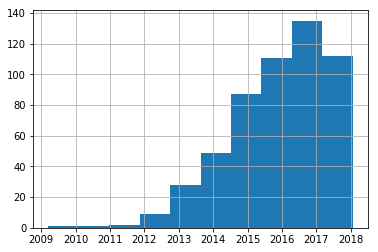

In [46]:
interviews['review_date'].hist()

Time to clean `job_title`, `application_process`, `interview_description`, and `interview_questions`

In [47]:
def cleaner(text):
    #simple text cleaning
    table = str.maketrans({punc:None for punc in string.punctuation})

        
    mapping = [('&#39;', ''), 
               ('<br />', ''), 
               ('<.*>.*</.*>', ''), 
               ('\\ufeff', ''), 
               ('[\d]', ''),  
               ('\[.*\]', ''),  
#                ('[^a-z ]', ''),
               ('question', ''),
               ('answer', ''), 
              ]
    if type(text) == str:
        for k, v in mapping:
            text = re.sub(k, v, text)
            text = text.translate(table)    
           
        #remove stop words
        text = " ".join([word for word in text.lower().split() if word not in eng_stop])

        # lemmatization 
        text = " ".join(lemma.lemmatize(word) for word in text.split())


    return text

In [48]:
eng_stop = set(stopwords.words('english'))
lemma = WordNetLemmatizer()

interviews['interview_questions'] = interviews['interview_questions'].str.lower().apply(cleaner)
interviews['application_proccess'] = interviews['application_proccess'].str.lower().apply(cleaner)
interviews['interview_description'] = interviews['interview_description'].str.lower().apply(cleaner)
interviews['job_title'] = interviews['job_title'].str.lower().apply(cleaner)

In [49]:
interviews.head()

,application_proccess,company,interview_description,interview_difficulty,interview_experience,interview_questions,job_title,offer_status,review_date
0,applied online process took week interviewed z...,Zillow,discussion recruiter positive courteous felt l...,Easy Interview,Negative Experience,NaN,senior software engineer,No Offer,2018-01-09
1,applied online process took week interviewed z...,Zillow,phone call call recruiter call sale manager pe...,Average Interview,Positive Experience,tell experience,account executive,Accepted Offer,2018-01-18
2,applied online process took week interviewed z...,Zillow,applied online within couple day recruiter rea...,Average Interview,Positive Experience,looking leave current job tell time profession...,data analyst,Accepted Offer,2018-01-16
3,process took week interviewed zillow denver co,Zillow,efficient friendly process started phone scree...,Average Interview,Positive Experience,zillow motivates sale tactic,business consultant,Accepted Offer,2018-01-05
4,applied employee referral interviewed zillow,Zillow,contacted recruiter set interview one marketin...,Easy Interview,Neutral Experience,tell tell marketing project done zillow,marketing strategy,Declined Offer,2018-01-08


The data is (roughly) cleaned up. Time to set up the topic modeling pipeline. I am starting with Non-negative Matrix Factorization (NMF), since it appears that the topics may be more reliable for relatively small numbers of documents. 

Consider revisiting to impliment Latent Dirichlet Allocation (LDA).

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
    
documents = interviews['interview_questions'][interviews['interview_questions'].notnull()]

In [51]:
#starting with tfidf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=500, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [52]:
len(tfidf_feature_names)

461

In [57]:
#nmf
nmf = NMF(n_components=5, random_state=1, alpha=0.1, l1_ratio=0.5, init='nndsvda')
nmf.fit(tfidf)

NMF(alpha=0.1, beta=1, eta=0.1, init='nndsvda', l1_ratio=0.5, max_iter=200,
  n_components=5, nls_max_iter=2000, random_state=1, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)

In [58]:
len(nmf.components_)

5

In [59]:
for topic_idx, topic in enumerate(nmf.components_):
    print("Topic {}:".format(topic_idx))
    print(["{}*{:1.4f}".format(tfidf_feature_names[i], topic[i])
                    for i in np.flip(topic.argsort(), axis=0)[:10]])
        
#figure out how to include weights

Topic 0:
['zillow*3.0106', 'know*0.0928', 'asked*0.0681', 'make*0.0672', 'role*0.0619', 'competitor*0.0355', 'want*0.0348', 'career*0.0337', 'used*0.0335', 'whats*0.0288']
Topic 1:
['tell*1.9883', 'experience*0.8209', 'time*0.4652', 'job*0.2145', 'previous*0.1363', 'interested*0.1346', 'resume*0.1116', 'asked*0.0914', 'lot*0.0853', 'place*0.0792']
Topic 2:
['tree*1.4537', 'trinary*0.6702', 'string*0.4972', 'insert*0.4563', 'delete*0.4537', 'implement*0.4197', 'node*0.4106', 'binary*0.3138', 'long*0.3046', 'convert*0.1588']
Topic 3:
['work*1.6014', 'want*1.4938', 'repetitive*0.2106', 'day*0.2024', 'time*0.1899', 'deal*0.1436', 'job*0.1231', 'environment*0.0975', 'team*0.0933', 'like*0.0694']
Topic 4:
['sale*1.7398', 'mock*0.3618', 'asked*0.2816', 'rep*0.1970', 'product*0.1966', 'motivates*0.1688', 'interested*0.1555', 'year*0.1458', 'sell*0.1419', 'experience*0.1410']


In [60]:
test = nmf.components_[0]